In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
qutip.settings.has_mkl = False # Fix the OS erros in VSCode
qutip.settings.num_cpus = 12

In [2]:
from utils import *
from sync_calcs import *
from sync_plots import *

# Qubit Husimi Q functions

In [3]:
# System constants and basis
J = .5 # Spin
N = int(2*J + 1) # Number of levels

u = basis(N, 0)
d = basis(N, 1)

In [4]:
# Plotting constants
n = 50  # angle array size scale

theta = np.linspace(0, np.pi, n)
phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)  # 1D vector -> 2D column vector



## States

In [5]:
# Add parameters of states to this list of dictionaries
# Hamiltonian -> density matrix are calculated
# Inline functions are evaluated
parameters = [
    {"gain_amp": 10, "loss_amp": 1, "signal_strength": 0, "detuning": 0},
    {"gain_amp": 10, "loss_amp": 1, "signal_strength": lambda g, l: 2 * min(g, l), "detuning": 0},
    {
        "gain_amp": 0.1,
        "loss_amp": 1,
        "signal_strength": lambda g, l: 2 * min(g, l),
        "detuning": lambda g, l: 3 * min(g, l),
    },
]


In [6]:
def process_parameters(*, signal_strength, detuning, gain_amp, loss_amp):
    if callable(signal_strength):
        signal_strength = signal_strength(gain_amp, loss_amp)
    if callable(detuning):
        detuning = detuning(gain_amp, loss_amp)

    return {"signal_strength": signal_strength, "detuning": detuning}


In [7]:
states = [{**params, "state": calculate_steady_state(**params), **process_parameters(**params)} for params in parameters]
selected_state = 2
state_dict = states[selected_state]

## Fully Computed Q Function

(<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
 <matplotlib.collections.QuadMesh at 0x258c2aad220>)

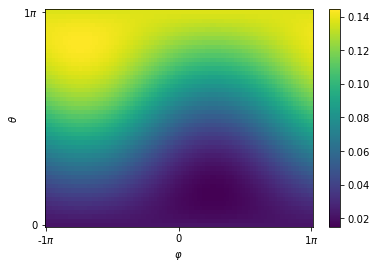

In [8]:
Q0 = my_spin_q_func(state_dict["state"], theta, phi)
plot_spin_qfunc(Q0.T, phi, theta)

## QuTip spin Q function

(<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
 <matplotlib.collections.QuadMesh at 0x258c2aebbe0>)

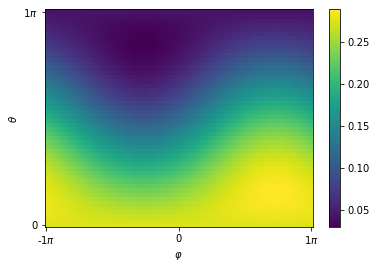

In [9]:
Q_qutip, *_ = spin_q_function(state_dict["state"], theta, phi)
plot_spin_qfunc(Q_qutip.T, phi, theta)

## Analytic spin Q function from Parra-López & Bergli

(<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
 <matplotlib.collections.QuadMesh at 0x258c2f24730>)

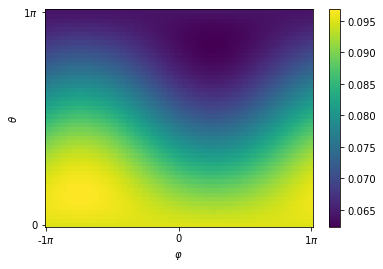

In [10]:
mx, my, mz = bloch_vector_comps(state_dict["gain_amp"], state_dict["loss_amp"], state_dict["detuning"], state_dict["signal_strength"])
Q_analytic = analytic_Q_function(mx, my, mz, phi, theta)

plot_spin_qfunc(Q_analytic.T, phi, theta)

## Custom Implementation of Spin Q function

(<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
 <matplotlib.collections.QuadMesh at 0x258c2c876d0>)

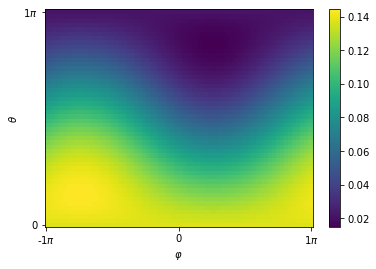

In [11]:
myQ = my_spin_q_func(state_dict["state"], theta, phi)
plot_spin_qfunc(myQ[:, ::-1].T, phi, theta)

## My Analytic Attempt for the Q function

In [12]:
st = np.sin(theta/2)
ct = np.cos(theta/2)

epip = np.exp(1j*phi/2)
emip = np.exp(-1j*phi/2)

A = st * emip
B = ct * epip

In [13]:
state = state_dict["state"]
Q = (A*A.conj()*state[1,1] + A.conj()*B*state[1,0] + A*B.conj()*state[0,1] + B*B.conj()*state[0,0]) / (2*np.pi)
assert np.count_nonzero(Q.imag) == 0 # All imag parts should be 0
Q = Q.real # Need real dtype

(<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
 <matplotlib.collections.QuadMesh at 0x258c2f7afa0>)

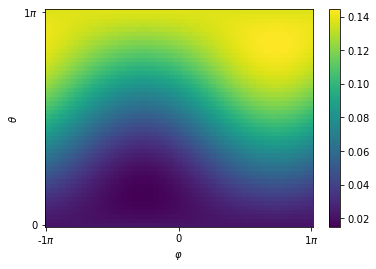

In [14]:
plot_spin_qfunc(Q.T, phi, theta)

## Synchronisation Measure from each Husimi Q function calculation

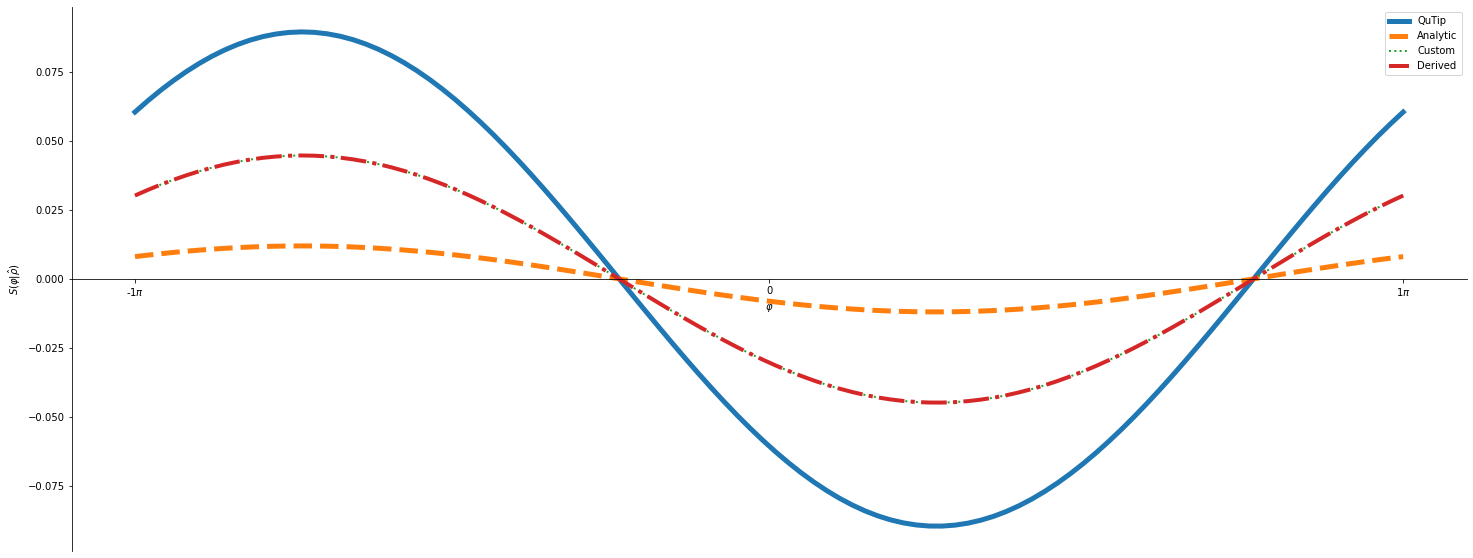

In [15]:
mx, my, mz = bloch_vector_comps(
    state_dict["gain_amp"],
    state_dict["loss_amp"],
    state_dict["detuning"],
    state_dict["signal_strength"],
)

fig, ax = plt.subplots(figsize=[25, 10])
# ax.spines["left"].set_position("zero")
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_position("zero")
ax.spines["top"].set_visible(False)

# S measure from QuTip Q function
S_qutip = spin_S_measure(theta, Q_qutip[::-1, ::-1] - 1 / (4 * np.pi))
plot_S_measure(S_qutip, phi, ax=ax, fig=fig, label="QuTip", lw=5)
# plot_S_measure(0.1335 * S_qutip, phi, ax=ax, fig=fig, label="QuTip Scaled $0.1335S$", lw=3)

# Analytic S measure
S_analytic = (1 / 8) * (mx * np.cos(phi) + my * np.sin(phi))
plot_S_measure(S_analytic, phi, ax=ax, fig=fig, ls="--", label="Analytic", lw=5)

# S measure of my Q function
myS = spin_S_measure(theta, myQ[:, ::-1])
plot_S_measure(myS, phi, ax=ax, fig=fig, ls=":", label="Custom", lw=2)
# ax.plot(phi, 0.266 * myS, ls=":", label=r"Custom Scaled $0.266S$", lw=2)

# S measure from my derived Q function
derivedS = spin_S_measure(theta, Q[::-1, ::-1])
plot_S_measure(derivedS, phi, ax=ax, fig=fig, ls="-.", label="Derived", lw=4)
# plot_S_measure(0.266 * derivedS, phi, ax=ax, fig=fig, ls="-.", label="Scaled Derived $0.266S$", lw=2)

ax.legend()
